<h1 style="text-align:center;">Stochastic Lotka–Volterra</h1>
<h3 style="text-align:center;">Stochastic Processes and Simulations in Natural Sciences (30561)</h3>
<h5 style="text-align:center;">Stoica Alexandru(3260547)   Dontu Catalin(3244174)   Antonescu Victor-Gabriel(3245562)</h3>

### Table of Contents:
1. Introduction
2. Libraries
3. The Deterministic Approach - ODE
4. Limitations of the Deterministic Approach
5. The Stochastic Approach - Gillespie Simulation
6. Extension of the Stochastic Approach
7. Conclusions

### 1. Introduction

The Lotka-Voltera Predator-Pray Model is represented by 2 first-order nonlinear differential equations. It is often used in biological systems in which 2 species interact. The population of the species evolves through time according to the following system:

$$
\begin{aligned}
\frac{dx(t)}{dt} &= \alpha x(t) - \beta x(t)y(t)\\[6pt]
\frac{dy(t)}{dt} &= -\gamma y(t) + \delta x(t)y(t) 
\end{aligned}
$$

$$
\alpha, \beta, \gamma, \delta \in \mathbb{R}_{+} \setminus \{0\}
$$

where  
- $x(t)$: prey population density at time t 
- $y(t)$: predator population density at time t 
- $\alpha$: prey's growth rate per capita
- $\beta$: effect of presence of predators on the prey's death rate
- $\gamma$: predator's death rate per capita
- $\delta$: effect of presence of pray on the predator's growth rate
- $t$: time

The deterministic model makes several **assumptions** about the environment and biology of the predator and prey population:

- **Unlimited Food Supply**: The prey population has an unlimited food supply at all times.
- **Relation Food Supply-Prey Population**: The food supply of the predator population depends entierly on the size of the prey population.
- **Continuous Population Growth**: The rate of change of population is proportional to its size.
- **Constant Environment**: The environment does not change during the process in favor of any species.
- **Continuous Predation**: Predators have limitless appettite.
- **Single Variables**: Populations are described by a single variable.

### 2. Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from ipywidgets import HTML, FloatSlider, Button, VBox, HBox, Output
import ipywidgets as widgets

import random
random.seed(42)

### 3. The Deterministic Approach – ODE

In this section we solve the **classical Lotka–Volterra Predator–Prey model** using ordinary differential equations (ODEs).
The model describes the interaction between a prey population and a predator population, as already mentioned in the introduction section.

Our goals in this section are:
- to **define the ODE system** mathematically,
- to **solve it numerically** using `scipy.integrate.odeint`,
- to **visualize the dynamics** of prey and predators over time,
- to **plot the phase portrait** (predator vs. prey),
- and to explore how the dynamics change interactively by varying the parameters with sliders.

In [2]:
# Store initial values for reset
INITIAL_VALUES = {
    'b': 0.5,
    'm': 0.5,
    'r': 0.02,
    'a': 0.01,
    'H0': 40,
    'P0': 9,
    't_max': 200 
}

EXTINCTION_THRESHOLD = 0.1

- `INITIAL_VALUES` stores default values for:
  - `b`: baseline rate at which prey reproduce.
  - `m`: baseline rate at which predators die in the absence of prey.
  - `r`: strength of predation (how quickly prey are removed per predator).
  - `a`: efficiency with which predators gain new individuals by consuming prey.
  - `H0` and `P0`: initial population sizes of prey and predators at time `t = 0`.
  - `t_max`: length of the simulated time interval.
- `EXTINCTION_THRESHOLD` defines a small population level below which a species is considered effectively extinct.
- Saving these values in a dictionary makes it easy to **reset the sliders** and also pass parameters into functions using keyword arguments.

In [3]:
# Model

def lotka_volterra(state, t, b, m, r, a):

    """
    Lotka-Volterra equations

    P = Predators, H = Prey

    Parameters:
    b: Birth rate of prey
    m: Death rate of predators
    r: Death rate of prey per predator
    a: Birth rate of predators per prey
    """

    H, P = state
    dH_dt = b*H - r*H*P
    dP_dt = -m*P + a*H*P
    return [dH_dt, dP_dt]

# Simulation

def simulate_lv(b, m, r, a, H0, P0, t_max, n_points=1000):

    """
    Solve the LV system and return t, H, P plus equilibrium values.
    """

    t = np.linspace(0, t_max, n_points)
    initial_state = [H0, P0]
    
    solution = odeint(lotka_volterra, initial_state, t, args=(b, m, r, a))
    H = solution[:, 0]
    P = solution[:, 1]
    
    # Equilibria 
    H_eq = m / a if a != 0 else 0
    P_eq = b / r if r != 0 else 0
    
    return t, H, P, H_eq, P_eq

- `lotka_volterra(state, t, b, m, r, a)` encodes the **deterministic predator–prey model**:
  - `state` contains the current populations `(H, P)`.
  - `dH_dt = b*H - r*H*P`:
    - `b*H` is the natural growth of the prey.
    - `r*H*P` is the loss of prey due to encounters with predators.
  - `dP_dt = -m*P + a*H*P`:
    - `-m*P` is the natural death of predators in the absence of prey.
    - `a*H*P` is the gain of predators due to successful predation.
- `simulate_lv(...)`:
  - Builds a time grid `t` from `0` to `t_max` with `n_points` steps.
  - Sets the initial state `[H0, P0]` and calls `odeint` to integrate the ODE system over time.
  - Extracts the prey trajectory `H(t)` and predator trajectory `P(t)` from the solution array.
  - Computes the **equilibrium point** \((H^*, P^*)\) where both derivatives are zero:
    - \(H^* = m/a\) (if `a ≠ 0`)
    - \(P^* = b/r\) (if `r ≠ 0`)
  - Returns all data needed for plotting: `t`, `H`, `P`, and the equilibrium values `H_eq`, `P_eq`.

In [4]:
# Plotting

def extinction_message(H, P, threshold=EXTINCTION_THRESHOLD):
    H_extinct = np.any(H < threshold)
    P_extinct = np.any(P < threshold)

    if H_extinct and P_extinct:
        return "Both species go extinct"
    elif H_extinct:
        return "Prey go extinct => Predators starve"
    elif P_extinct:
        return "Predators go extinct => Prey explode"
    return ""


def plot_lv(t, H, P, H_eq, P_eq, params, initial_state):

    """
    Draw the time series and phase-space plots.
    params: dict with keys 'b','m','r','a'
    initial_state: (H0, P0)
    """

    b, m, r, a = params['b'], params['m'], params['r'], params['a']
    H0, P0 = initial_state

    msg = extinction_message(H, P)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Time series
    ax1.plot(t, H, label='Prey (H)', linewidth=2)
    ax1.plot(t, P, label='Predators (P)', linewidth=2)

    if a > 0 and m > 0:
        ax1.axhline(y=H_eq, linestyle='--', alpha=0.5,
                    label=f'Prey eq: {H_eq:.1f}')
    if r > 0 and b > 0:
        ax1.axhline(y=P_eq, linestyle='--', alpha=0.5,
                    label=f'Pred eq: {P_eq:.1f}')

    title = 'Population Dynamics Over Time'
    if msg:
        title += f'\n{msg}'
    ax1.set_title(title)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population')
    ax1.set_ylim(bottom=0)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Phase-space
    ax2.plot(H, P, linewidth=2)
    ax2.plot(H0, P0, 'ko', markersize=10, label=f'Initial ({H0:.0f}, {P0:.0f})')

    if a > 0 and m > 0 and r > 0 and b > 0:
        ax2.plot(H_eq, P_eq, 'ro', markersize=8,
                 label=f'Equilibrium ({H_eq:.1f}, {P_eq:.1f})')
        ax2.axvline(x=H_eq, linestyle=':', alpha=0.5)
        ax2.axhline(y=P_eq, linestyle=':', alpha=0.5)

    ax2.set_title('Phase Space (Predator vs Prey)')
    ax2.set_xlabel('Prey (H)')
    ax2.set_ylabel('Predators (P)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

- `extinction_message(H, P, threshold)`:
  - Checks whether the prey or predator populations ever fall below the extinction threshold.
  - Returns a short qualitative message describing the scenario.
  
- `plot_lv(t, H, P, H_eq, P_eq, params, initial_state)`:
  - Creates a **time-series plot** of `H(t)` (prey) and `P(t)` (predators).
  - Draws **horizontal lines** at the equilibrium populations `H_eq` and `P_eq` when they are defined.
  - Displays an extinction message above the plot if extinction occurs.
  - Creates a **phase-space plot** (predators vs. prey) showing the trajectory in the `(H, P)` plane.
  - Marks the equilibrium point \((H^*, P^*)\) and adds dotted reference lines through it.
  - Adds titles, labels, legend, and grid for readability, then calls `plt.show()` to render the figure.

In [5]:
# Widget Construction for Visualization

# Sliders
b_slider = FloatSlider(min=0.0, max=2.0, step=0.1,
                       value=INITIAL_VALUES['b'],
                       description='b (birth)', continuous_update=True)

m_slider = FloatSlider(min=0.0, max=2.0, step=0.1,
                       value=INITIAL_VALUES['m'],
                       description='m (death)', continuous_update=True)

r_slider = FloatSlider(min=0.0, max=0.1, step=0.005,
                       value=INITIAL_VALUES['r'],
                       description='r (death)', continuous_update=True)

a_slider = FloatSlider(min=0.0, max=0.1, step=0.005,
                       value=INITIAL_VALUES['a'],
                       description='a (birth)', continuous_update=True)

H0_slider = FloatSlider(min=0, max=100, step=5,
                        value=INITIAL_VALUES['H0'],
                        description='H0 (initial)', continuous_update=True)

P0_slider = FloatSlider(min=0, max=100, step=2,
                        value=INITIAL_VALUES['P0'],
                        description='P0 (initial)', continuous_update=True)

t_max_slider = FloatSlider(min=50, max=500, step=50,
                           value=INITIAL_VALUES['t_max'],
                           description='Time span', continuous_update=True)

# Buttons
only_prey_btn = Button(description="Only Prey Case",
                       button_style='info',
                       tooltip='Set parameters for prey-only scenario')

only_predators_btn = Button(description="Only Predators Case",
                            button_style='info',
                            tooltip='Set parameters for predator-only scenario')

equilibrium_btn = Button(description="Equilibrium Case",
                         button_style='success',
                         tooltip='Set classic parameters with equilibrium start')

reset_all_btn = Button(description="Reset All Parameters",
                       button_style='warning',
                       tooltip='Reset ALL parameters to initial values')

# Output area
output = Output()

prey_title = HTML("<b>Prey parameters:</b>")
pred_title = HTML("<b>Predator parameters:</b>")

# Layout
left_column = VBox(
    [prey_title, b_slider, r_slider, H0_slider],
    layout=widgets.Layout(align_items='center')
)

right_column = VBox(
    [pred_title, m_slider, a_slider, P0_slider],
    layout=widgets.Layout(align_items='center')
)

scenario_button_row = HBox(
    [only_prey_btn, equilibrium_btn, only_predators_btn],
    layout=widgets.Layout(justify_content='center', margin='5px 0')
)

utility_button_row = HBox(
    [reset_all_btn],
    layout=widgets.Layout(justify_content='center', margin='5px 0')
)

top_row = HBox(
    [left_column, right_column],
    layout=widgets.Layout(justify_content='center')
)

bottom_row = VBox(
    [scenario_button_row, utility_button_row, t_max_slider],
    layout=widgets.Layout(align_items='center')
)

dashboard_title = widgets.HTML(
    "<h2 style='text-align:center; margin-bottom:10px;'>Visualization Dashboard</h2>"
)

ui = VBox([dashboard_title, top_row, bottom_row])

- Sliders:
  - One slider for each model parameter (`b`, `m`, `r`, `a`) and each initial condition (`H0`, `P0`, `t_max`).
  - The sliders are initialized using the values in `INITIAL_VALUES`.
  - Moving a slider will update the corresponding parameter in the simulation.
- Buttons:
  - Provide quick presets such as “Only prey”, “Only predators”, “Equilibrium”, and “Reset”.
  - When clicked, they overwrite the slider values with specific parameter combinations (handled in the callbacks).
- Layout (`VBox`, `HBox`):
  - `VBox` stacks sliders and buttons vertically in a control panel.
  - `HBox` places the control panel next to the plotting `output` area for a clean, interactive interface.

In [6]:
# Callbacks

def read_params_from_sliders():
    return dict(
        b=b_slider.value,
        m=m_slider.value,
        r=r_slider.value,
        a=a_slider.value,
        H0=H0_slider.value,
        P0=P0_slider.value,
        t_max=t_max_slider.value,
    )

def plot_lotka_volterra(b, m, r, a, H0, P0, t_max):

    """
    Wrapper for interactive_output
    """
    
    output.clear_output(wait=True)
    with output:
        t, H, P, H_eq, P_eq = simulate_lv(b, m, r, a, H0, P0, t_max)
        params = {'b': b, 'm': m, 'r': r, 'a': a}
        plot_lv(t, H, P, H_eq, P_eq, params, (H0, P0))


# Button actions
def only_prey_case(_):
    m_slider.value = 1.0
    a_slider.value = 0.0
    r_slider.value = 0.0
    P0_slider.value = 0.0

def only_predators_case(_):
    b_slider.value = 0.0
    H0_slider.value = 0.0
    r_slider.value = 0.0

def equilibrium_case(_):
    b_slider.value = 0.5
    m_slider.value = 0.5
    r_slider.value = 0.02
    a_slider.value = 0.01

    H_eq = m_slider.value / a_slider.value
    P_eq = b_slider.value / r_slider.value

    H0_slider.value = H_eq
    P0_slider.value = P_eq

def reset_initial_numbers(_):
    for k, v in INITIAL_VALUES.items():
        if k == 'b':   b_slider.value = v
        elif k == 'm': m_slider.value = v
        elif k == 'r': r_slider.value = v
        elif k == 'a': a_slider.value = v
        elif k == 'H0': H0_slider.value = v
        elif k == 'P0': P0_slider.value = v
        elif k == 't_max': t_max_slider.value = v

# Link buttons
only_prey_btn.on_click(only_prey_case)
only_predators_btn.on_click(only_predators_case)
equilibrium_btn.on_click(equilibrium_case)
reset_all_btn.on_click(reset_initial_numbers)

- `read_params_from_sliders()`:
  - Reads the current values from all sliders and packs them into a dictionary.
  - This is useful for passing the current slider settings to the simulation and plotting functions.
- `plot_lotka_volterra(...)`:
  - Acts as a **wrapper** between the sliders and the plotting code.
  - Calls `simulate_lv` with the current parameter values to get `t`, `H`, `P`, and equilibrium values.
  - Clears the previous plot in `output` and calls `plot_lv` to draw the new figure.
- Button callbacks:
  - Each button click callback updates selected sliders to a predefined scenario.
  - After sliders change, the linked plot is automatically updated.

In [7]:
# Initial Display

display(ui)

out = widgets.interactive_output(
    
    plot_lotka_volterra,
    {
        'b': b_slider,
        'm': m_slider,
        'r': r_slider,
        'a': a_slider,
        'H0': H0_slider,
        'P0': P0_slider,
        't_max': t_max_slider
    }
)

display(output)

# Initial plot
plot_lotka_volterra(**INITIAL_VALUES)

Output()

The classical Lotka–Volterra system gives us a clean and mathematically elegant description of predator–prey interactions. It reveals important qualitative features such as:

- closed orbits representing population cycles,
- a neutrally stable equilibrium point,
- the dependence of oscillation shape on the initial conditions.

### 4. Limitations of the Deterministic Approach

The previous deterministic formulation has some **significant limitations**:

1. **Predictability:**  
   The ODE assumes that populations change smoothly and continuously, ignoring the randomness present in real ecological systems.

2. **No population discreteness:**  
   Prey and predators are treated as continuous variables, even though they are composed of individual organisms.

3. **No extinction events:**  
   The deterministic model never allows populations to reach true extinction, even when numbers drop very.

4. **No environmental variability:**  
   Real ecosystems experience fluctuations in resources, temperature, reproduction, and death rates. These cannot be captured in a purely deterministic framework.

5. **Conserved cycles (no damping or spiraling):**  
   The classical model predicts perfectly repeated cycles. Real ecosystems rarely follow such ideal periodic behavior.

#### Example 1 – No discreteness or extinction

If we start with very small populations, the deterministic ODE model still
treats prey and predators as continuous variables. The trajectories can get
arbitrarily close to zero, but never actually reach extinction.

In a real
system with individual organisms, the population would jump from 1 to 0 in a
single event (this representing true extintion).

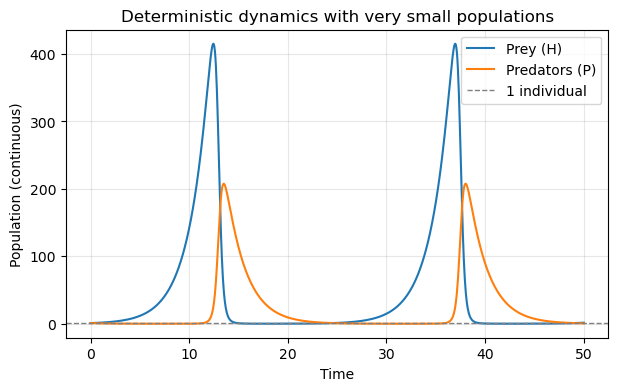

In [8]:
def small_populations():
    # Parameters 
    b, m, r, a = 0.5, 0.5, 0.02, 0.01

    # Very small initial populations
    H0, P0 = 1, 1
    t_max = 50

    t, H, P, H_eq, P_eq = simulate_lv(b, m, r, a, H0, P0, t_max)

    plt.figure(figsize=(7, 4))
    plt.plot(t, H, label="Prey (H)")
    plt.plot(t, P, label="Predators (P)")
    plt.axhline(1, color='gray', linestyle='--', linewidth=1, label='1 individual')

    plt.title("Deterministic dynamics with very small populations")
    plt.xlabel("Time")
    plt.ylabel("Population (continuous)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

small_populations()

#### Example 2 – Perfect, undamped cycles

The deterministic Lotka–Volterra model predicts closed orbits that repeat forever. Even if we change the initial conditions slightly, each trajectory stays on a perfect periodic cycle and never spirals in or out.

This is very unlikely for most of the real-world Predator–Prey systems.

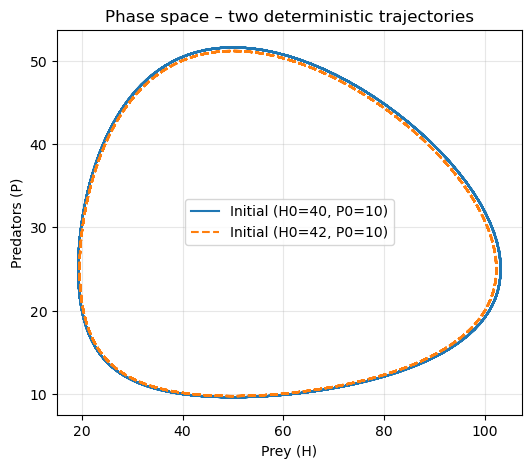

In [9]:
def perfect_cycles():
    b, m, r, a = 0.5, 0.5, 0.02, 0.01
    t_max = 150

    H0_1, P0_1 = 40, 10
    H0_2, P0_2 = 42, 10

    t1, H1, P1, _, _ = simulate_lv(b, m, r, a, H0_1, P0_1, t_max)
    t2, H2, P2, _, _ = simulate_lv(b, m, r, a, H0_2, P0_2, t_max)

    plt.figure(figsize=(6, 5))

    # Phase space: predators vs prey
    plt.plot(H1, P1, label=f"Initial (H0={H0_1}, P0={P0_1})")
    plt.plot(H2, P2, label=f"Initial (H0={H0_2}, P0={P0_2})", linestyle='--')

    plt.title("Phase space – two deterministic trajectories")
    plt.xlabel("Prey (H)")
    plt.ylabel("Predators (P)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

perfect_cycles()

On the other hand, a stochastic model allows us to incorporate randomness, individual-level interactions, and the possibility of extinction. These features often make the behavior of ecological systems fundamentally different from the predictions of the deterministic ODE.

In the next section, we will introduce a ***stochastic simulation approach*** to capture these more realistic dynamics.

### 5. The Stochastic Approach – Gillespie Simulation

IGNORATI ASTA, NU ARE NEAPARAT SENS INCA

***Why Gillespie Algorithm?***

The dynamics of the predator–prey model can be expressed as **discrete random events** with well-defined rates. This fits the assumptions of the Gillespie framework: events (reactions) occur one at a time, each with its own probability rate, and the future evolution depends only on the **current state** (Markov property).

In this view, the Lotka–Volterra system is modeled as a **Continuous-Time Markov Jump Process (CTMJP)**. The state of the system at time $t$ is the vector $(X(t), Y(t))$, where $X$ is the number of prey and $Y$ the number of predators. The process jumps whenever one of the following reaction channels fires:

- **Prey reproduction**  
  $$X \xrightarrow{\alpha} 2X$$
  Each prey can reproduce, so the rate is proportional to the current number of prey:  
  $$a_1 = \alpha X.$$

- **Predation (prey eaten, predator reproduces)**  
  $$X + Y \xrightarrow{\beta} 2Y$$
  A prey–predator encounter removes one prey and produces one new predator, with rate  
  $$a_2 = \beta X Y.$$

- **Predator death**  
  $$Y \xrightarrow{\delta} \varnothing$$
  Each predator can die, so the rate is proportional to the number of predators:  
  $$a_3 = \delta Y.$$

The **propensity functions** $a_1, a_2, a_3$ give the probability per unit time that each reaction occurs in the current state $(X, Y)$. The **total propensity** is
$$
a_0 = a_1 + a_2 + a_3.
$$

Gillespie’s Stochastic Simulation Algorithm (SSA) then generates an exact sample path of this Markov jump process by repeating the following steps:

1. Draw the waiting time to the next reaction from an exponential distribution  
   $$
   \tau \sim \text{Exponential}(a_0),
   $$
   which in code is implemented as
   $$
   \tau = -\frac{\ln(U)}{a_0}, \quad U \sim \text{Uniform}(0,1).
   $$

2. Choose which reaction fires with probability
   $$
   \mathbb{P}(R_i \text{ fires}) = \frac{a_i}{a_0}, \quad i = 1,2,3.
   $$
   In the code, this is done by drawing a uniform random number in $[0, a_0)$ and selecting the reaction by cumulative sum over $a_1, a_2, a_3$.

3. Update the state $(X, Y)$ according to the chosen reaction:
   - $R_1$: $(X, Y) \to (X+1,\, Y)$  
   - $R_2$: $(X, Y) \to (X-1,\, Y+1)$  
   - $R_3$: $(X, Y) \to (X,\, Y-1)$  

Repeating these steps produces the stochastic trajectories you plot in the code, capturing discreteness, randomness, and extinction events—features that are absent from the deterministic ODE solution.

In [10]:
def something():
    pass

### 6. Extension of the Stochastic Approach

Ways to improve the convergence time of the Gillespie Algorithm, which tend to be very slow.

### 7. Conclusions

blah blah blah 